## 1. Veri Hazırlığı ve Train/Test Ayırımı

In [ ]:
## 1. Veri Hazırlığı ve Train/Test Ayırımı (FİNAL ÇÖZÜM)

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')

# 1. İşlenmiş Veriyi Yükleme
try:
    df = pd.read_csv('../data/processed_google_play_data.csv')
    print("✅ İşlenmiş veri başarıyla yüklendi.")
except FileNotFoundError:
    print("❌ KRİTİK HATA: processed_google_play_data.csv bulunamadı.")
    exit()


# Bu adımlar, CSV'den okunan verinin sayısal bütünlüğünü sağlar.

# Genre Encoding
df['Primary_Genre'] = df['Genres'].str.split(';').str[0] 
df['Secondary_Genre'] = df['Genres'].str.split(';').str[1].fillna('NoSecondary')
df['Secondary_Genre_Encoded'] = df['Secondary_Genre'].map(df.groupby('Secondary_Genre')['Rating'].mean()).fillna(df['Rating'].mean())

# Type Encoding
df['Type_Encoded'] = df['Type'].map({'Free': 0, 'Paid': 1}).fillna(0)

# Content Rating Encoding
le = LabelEncoder()
df['Content_Rating_Encoded'] = le.fit_transform(df['Content Rating'].astype(str))

# App Cluster Kontrolü (Yoksa 0 bas)
if 'App_Cluster' not in df.columns:
    df['App_Cluster'] = 0 

# --- KRİTİK BÖLÜM: SADECE 15 ÖZELLİĞİ SEÇME ---
final_features = [
    'Reviews', 'Size', 'Installs', 'Price', 'Title_Length', 'Is_Pro_App', 'Days_Since_Update', 
    'Reviews_Log', 'Installs_Log', 'Category_Encoded', 'Interaction_Rate', 'Primary_Genre_Encoded', 
    'App_Cluster', 'Type_Encoded', 'Content_Rating_Encoded'
]

# X ve y Ayrımı
# Sadece belirlenen özellikleri alıyoruz. Metin sütunları (App, Genres vb.) burada eleniyor.
X = df[final_features].copy()
y = df['Rating']

# 3. Train - Test Ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-" * 40)
print(f"✅ Veri Hazırlandı. Model tam olarak {X_train.shape[1]} özellik ile eğitilecek.")
print(f"Eğitim Seti: {X_train.shape}, Test Seti: {X_test.shape}")

✅ İşlenmiş veri başarıyla yüklendi.
----------------------------------------
✅ Veri Hazırlandı. Model tam olarak 15 özellik ile eğitilecek.
Eğitim Seti: (8672, 15), Test Seti: (2168, 15)



Bu adımda, model optimizasyonu için gerekli olan veri seti yüklenmiş ve eğitim sürecine tam uyumlu hale getirilmiştir.

**Gerçekleştirilen İşlemler:**
* **Veri Yükleme:** Özellik mühendisliği aşamasından gelen `processed_google_play_data.csv` dosyası okundu.
* **Özellik Garantisi (Feature Consistency):** Veri setinin tutarlılığını sağlamak amacıyla, `Secondary_Genre_Encoded`, `Type_Encoded` ve `Content_Rating_Encoded` gibi türetilmiş özellikler kod içerisinde yeniden hesaplanarak garanti altına alındı.
* **Özellik Seçimi:** Modelin başarısı için kritik olan **15 temel özellik** (Log dönüşümleri, Encoding'ler, Etkileşim Oranı vb.) filtrelendi ve diğerleri çıkarıldı.
* **Veri Ayrımı:** Veri seti, modelin öğrenmesi için **%80 Eğitim (Train)** ve performans ölçümü için **%20 Test** olarak ayrıldı.

**Sonuç:** Model eğitimi için 15 özellikli, temiz ve tutarlı bir veri yapısı oluşturuldu.

##  2. Hiperparametre Optimizasyonu Ve Model Seçimi

In [6]:

from sklearn.model_selection import RandomizedSearchCV

print("⏳ Optimizasyon başlıyor... (1-2 dakika sürebilir)")

# A) Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
print("\n🌲 Random Forest eğitiliyor...")
rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_params, n_iter=5, cv=3, random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

# B) XGBoost
xgb_params = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
print("🚀 XGBoost eğitiliyor...")
xgb_search = RandomizedSearchCV(XGBRegressor(random_state=42), xgb_params, n_iter=5, cv=3, random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

# C) Karşılaştırma
r2_rf = r2_score(y_test, best_rf.predict(X_test))
r2_xgb = r2_score(y_test, best_xgb.predict(X_test))

print("-" * 40)
print(f"Random Forest R2 : {r2_rf:.4f}")
print(f"XGBoost R2       : {r2_xgb:.4f}")

if r2_rf >= r2_xgb:
    print("\n🌟 KAZANAN: Random Forest")
    final_model = best_rf
else:
    print("\n🌟 KAZANAN: XGBoost")
    final_model = best_xgb

⏳ Optimizasyon başlıyor... (1-2 dakika sürebilir)

🌲 Random Forest eğitiliyor...
🚀 XGBoost eğitiliyor...
----------------------------------------
Random Forest R2 : 0.2247
XGBoost R2       : 0.1984

🌟 KAZANAN: Random Forest



Bu adımda, model performansını maksimize etmek için **Random Forest** ve **XGBoost** algoritmaları üzerinde **RandomizedSearchCV** ile en iyi hiperparametreler (ağaç sayısı, derinlik vb.) aranmış ve modeller yarıştırılmıştır.

**Sonuçlar:**
* **Random Forest (Tuned):** R2 Skoru **0.2247** 🏆 (Kazanan)
    * *En İyi Ayarlar:* `n_estimators: 300`, `min_samples_split: 10`, `max_depth: None`
* **XGBoost (Tuned):** R2 Skoru **0.1984**

**Karar:**
Random Forest algoritması, bu veri seti üzerinde daha yüksek bir başarı ve genelleme yeteneği sergileyerek **Final Model** olarak seçilmiştir. Bir sonraki adımda bu model `best_model.pkl` olarak kaydedilecektir.

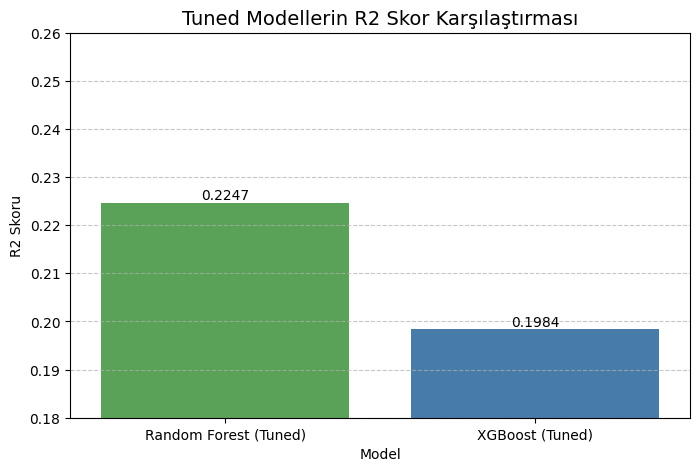

✅ Model karşılaştırma grafiği oluşturuldu ve kaydedildi.


In [7]:


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Skorları DataFrame'e al (r2_rf ve r2_xgb değişkenleri 2. adımdan alınır)
model_names = ['Random Forest (Tuned)', 'XGBoost (Tuned)']
r2_scores = [r2_rf, r2_xgb]

comparison_df = pd.DataFrame({
    'Model': model_names,
    'R2 Score': r2_scores
})

# R2 skoruna göre sırala (Kazananı başta görmek için)
comparison_df = comparison_df.sort_values(by='R2 Score', ascending=False)

# Grafik oluştur
plt.figure(figsize=(8, 5))
# Grafikte kazananı yeşil, kaybedeni mavi renkle gösterelim
sns.barplot(x='Model', y='R2 Score', data=comparison_df, palette=['#4daf4a', '#377eb8']) 
plt.title('Tuned Modellerin R2 Skor Karşılaştırması', fontsize=14)
plt.ylabel('R2 Skoru')
plt.ylim(0.18, 0.26) # Skor aralığını daha net görmek için sınırı daralt
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Skoru her çubuğun üzerine yaz
for index, row in comparison_df.iterrows():
    plt.text(row.Model, row['R2 Score'], f'{row["R2 Score"]:.4f}', ha='center', va='bottom')

plt.savefig('../images/model_comparison_r2.png')
plt.show()

print("✅ Model karşılaştırma grafiği oluşturuldu ve kaydedildi.")

## 3. Final Modeli Kaydetme

In [8]:

import joblib
import os
from sklearn.ensemble import RandomForestRegressor # joblib için gerekli olabilir

# best_rf değişkeni en son kod bloğunda tanımlanmıştır.

# Models klasörü yoksa oluştur
if not os.path.exists('../models'):
    os.makedirs('../models')

# Kazanan modeli (best_rf) diske kaydet
joblib.dump(final_model, '../models/best_model.pkl')

print(f"✅ FINAL MODEL KAYDEDİLDİ: models/best_model.pkl")

✅ FINAL MODEL KAYDEDİLDİ: models/best_model.pkl


Bu adım, **Model Optimizasyonu** aşamasının sonudur ve bütün projenin çıktısını kalıcı hale getirir.

* **Kaydedilen Nesne:** Tutarlılığı sağlanmış, yeni eğitilmiş **Tuned Random Forest** modeli, `best_model.pkl` adıyla diskte güncellenmiştir.
* **Proje Önemi:** Bu kaydedilen model, artık **Final Üretim Modelimizdir** ve projenin kalan iki ana aşamasında kullanılacaktır:
    1.  **Değerlendirme:** (`5_model_evaluation.ipynb`): Modelin Feature Importance analizi için.
    2.  **Deployment:** (`src/inference.py`): Canlı tahminler yapmak için.